In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
from pystoi import stoi # entre 0 et 1. Plus c'est proche de 1, mieux c'est
import scipy
import torchmetrics
from torch.utils.data import DataLoader
from torchmetrics.audio.pesq import PerceptualEvaluationSpeechQuality
import torch
from dummy import Dummy
import torch.nn as nn
import torch.nn.functional as F
import IPython.display as ipd
from scipy.signal import stft, istft
from dummy_model import Dummy_model
import tqdm
import pandas as pd

c:\Users\grego\miniconda3\envs\map588\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SAMPLERATE = 8000

Localisation des fichiers : 

In [3]:
test_files_noise = os.listdir('./data/Audio/denoising/test/test/')
train_files_noise = os.listdir('./data/Audio/denoising/train/train/')
test_files_clean = os.listdir('./data/Audio/voice_origin/test/test/')
train_files_clean = os.listdir('./data/Audio/voice_origin/train/train/')

Visualisation de quelques signaux

In [4]:
index=9
file_clean='./data/Audio/voice_origin/train/train/' + train_files_clean[index]
file_noise='./data/Audio/denoising/train/train/' + train_files_noise[index]
samplerate_clean, data_clean = wavfile.read(file_clean) # sample rate is the sample freqnency of the audio
samplerate_noise, data_noise = wavfile.read(file_noise)


On commence par transformer les données en stft et les stocker dans data. 
On stocke le stft normalisé (toutes les valeurs sont entre 0 et 1). 


In [5]:
convert_files = False 
# set to True to convert the files to spectrogrammes
if convert_files: 
    np.random.seed(0)
    for i in tqdm.tqdm(range(len(test_files_noise))):
        file = test_files_noise[i]
        samplerate, data = wavfile.read('./data/Audio/denoising/test/test/' + file)
        frequencies, times, Zxx = stft(data, fs=samplerate, nperseg=500)
        pd.DataFrame(data=Zxx).to_csv('./data/spectrogrammes/test/noisy/' + file + '.csv')

    for i in tqdm.tqdm(range(len(test_files_clean))):
        file = test_files_noise[i]
        samplerate, data = wavfile.read('./data/Audio/voice_origin/test/test/' + file)
        frequencies, times, Zxx = stft(data, fs=samplerate, nperseg=500)
        pd.DataFrame(data=Zxx).to_csv('./data/spectrogrammes/test/origin/' + file + '.csv')
        
    for i in tqdm.tqdm(range(len(train_files_noise))):
        file = train_files_noise[i]
        samplerate, data = wavfile.read('./data/Audio/denoising/train/train/' + file)
        samplerate_clean, data_clean=wavfile.read('./data/Audio/voice_origin/train/train/' + file)
        frequencies, times, Zxx = stft(data, fs=samplerate, nperseg=500)
        frequencies_clean, times_clean, Zxx_clean = stft(data_clean, fs=samplerate_clean, nperseg=500)
        if np.random.random() > 0.8 :
            pd.DataFrame(data=Zxx).to_csv('./data/spectrogrammes/validation/noisy/' + file + '.csv')
            pd.DataFrame(data=Zxx_clean).to_csv('./data/spectrogrammes/validation/origin/' + file + '.csv')
        else : 
            pd.DataFrame(data=Zxx).to_csv('./data/spectrogrammes/train/noisy/' + file + '.csv')
            pd.DataFrame(data=Zxx_clean).to_csv('./data/spectrogrammes/train/origin/' + file + '.csv')


Conversion en fichiers .npy

In [6]:
# conversion en npy : 
convert_files = False
  
if convert_files: 
    np.random.seed(0)
    for i in tqdm.tqdm(range(len(test_files_noise))):
        file = test_files_noise[i]
        samplerate, data = wavfile.read('./data/Audio/denoising/test/test/' + file)
        frequencies, times, Zxx = stft(data, fs=samplerate, nperseg=500)
        np.save('./data/spectrogrammes/test/noisy/' + file + '.npy', Zxx)

    for i in tqdm.tqdm(range(len(test_files_clean))):
        file = test_files_noise[i]
        samplerate, data = wavfile.read('./data/Audio/voice_origin/test/test/' + file)
        frequencies, times, Zxx = stft(data, fs=samplerate, nperseg=500)
        np.save('./data/spectrogrammes/test/origin/' + file + '.npy', Zxx)
        
    for i in tqdm.tqdm(range(len(train_files_noise))):
        file = train_files_noise[i]
        samplerate, data = wavfile.read('./data/Audio/denoising/train/train/' + file)
        samplerate_clean, data_clean=wavfile.read('./data/Audio/voice_origin/train/train/' + file)
        frequencies, times, Zxx = stft(data, fs=samplerate, nperseg=500)
        frequencies_clean, times_clean, Zxx_clean = stft(data_clean, fs=samplerate_clean, nperseg=500)
        if np.random.random() > 0.8 :
            np.save('./data/spectrogrammes/validation/noisy/' + file + '.npy', Zxx)
            np.save('./data/spectrogrammes/validation/origin/' + file + '.npy', Zxx_clean)
        else : 
            np.save('./data/spectrogrammes/train/noisy/' + file + '.npy', Zxx)
            np.save('./data/spectrogrammes/train/origin/' + file + '.npy', Zxx_clean)

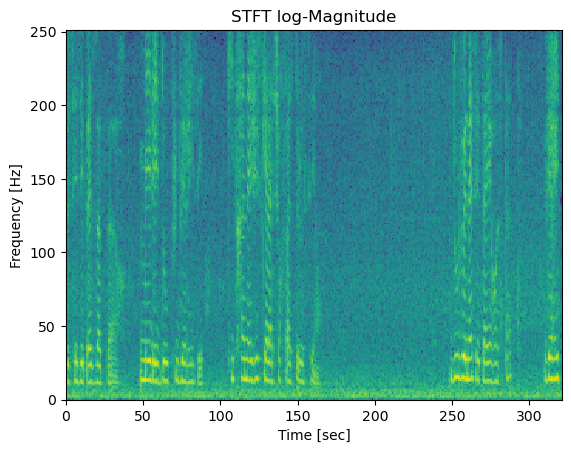

In [ ]:
# visualisation d'un spectrogramme
try : 
    file = train_files_noise[index]
    Zxx = np.load('./data/spectrogrammes/train/noisy/' + file + '.npy')
    plt.pcolormesh(np.log(np.abs(Zxx)))
    plt.title('STFT log-Magnitude')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.savefig('spectrogramme.png')
    plt.show()
except :
    from PIL import Image
    img = Image.open('spectrogramme.png')
    display(img)


Création de datasets d'entrainement, de validation et de test. 

In [8]:
class Mydataset(torch.utils.data.Dataset):
    def __init__(self, path_to_data):
        self.path_to_data = path_to_data
        self.X = [elt for elt in os.listdir(path_to_data + 'noisy/') if 'npy' in elt]
        self.Y = [elt for elt in os.listdir(path_to_data + 'origin/') if 'npy' in elt]


    def __len__(self):
        assert len(self.X) == len(self.Y)
        return len(self.X)

    def __getitem__(self, idx):
        noised=np.load(self.path_to_data + 'noisy/' + self.X[idx], allow_pickle=True)
        noised_real=noised.real
        noised_imag=noised.imag
        origin=np.load(self.path_to_data + 'origin/' + self.Y[idx],  allow_pickle=True)
        origin_real=origin.real
        origin_imag=origin.imag
        return torch.tensor([noised_real, noised_imag]), torch.tensor([origin_real, origin_imag]) # 1, 129, 357 chacuns 

Création de dataloaders

In [9]:
dataloader_test = DataLoader(Mydataset('./data/spectrogrammes/test/'), batch_size=10 , shuffle=True)
dataloader_train = DataLoader(Mydataset('./data/spectrogrammes/train/'), batch_size=10 , shuffle=True)
dataloader_validation = DataLoader(Mydataset('./data/spectrogrammes/validation/'), batch_size=10 , shuffle=True)
for batch in dataloader_test :
  print(batch[0].shape, batch[1].shape)
  break
print("il y a deux canaux au début, un pour la partie réelle et un pour la partie imaginaire")

C:\Users\grego\AppData\Local\Temp\ipykernel_23180\1791884614.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:264.)
  return torch.tensor([noised_real, noised_imag]), torch.tensor([origin_real, origin_imag]) # 1, 129, 357 chacuns


torch.Size([10, 2, 251, 321]) torch.Size([10, 2, 251, 321])
il y a deux canaux au début, un pour la partie réelle et un pour la partie imaginaire


Dummy model as a baseline 

In [10]:
class Dummy_model(nn.Module): 
    def __init__(self): 
        super(Dummy_model, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=2, out_channels=1,  kernel_size=11, stride=1, padding='same')
    def forward(self, x): # [10, 2, 251, 321]
        x = self.conv1(x)
        x = F.relu(x) # [10, 1, 251, 321]
        return x
    

In [11]:
class Small_Unet (nn.Module):

  def __init__(self):
    super(Small_Unet, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=2, out_channels=16, kernel_size=(11, 11), stride=2, padding=5)
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(8, 8), stride=2, padding=4)
    self.deconv1 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=(8, 8), stride=2, padding=4, output_padding=1)
    # drop a dimension in the output to go from [10, 16, 127, 161] to [10, 16, 126, 161] 
    self.deconv2 = nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=(11, 11), stride=2, padding=5)
    

  def forward(self, x): # x = [10, 2, 251, 321]
    x = F.relu(self.conv1(x)) # [10, 16, 126, 161]
    x = F.relu(self.conv2(x)) # [10, 32, 64, 81]
    x = F.relu(self.deconv1(x)) #[10, 16, 127, 161]
    x = x[:, :, :126, :] # slicing nécessaire pour que les dimensions correspondent, car la convolution transpose n'est pas l'inverse de la convolution x.shape -> #[10, 16, 127, 161]
    x = F.relu(self.deconv2(x)) #[10, 1, 251, 321]
    return x # on ressort un masque


In [12]:

class UNet(nn.Module): 
    def __init__(self):
        super(UNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=2, out_channels=32, kernel_size=(5, 5), stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5, 5), stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(5, 5), stride=2)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(5, 5), stride=2)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(5, 5), stride=2)
        self.deconv1 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=(6, 6), stride=2)
        self.deconv2 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=(6, 6), stride=2)
        self.deconv3 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=(6, 6), stride=2)
        self.deconv4 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=(6, 6), stride=2)
        self.deconv5 = nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=(5, 5), stride=2)

        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm2d(512)
        self.bn_deconv1 = nn.BatchNorm2d(256)
        self.bn_deconv2 = nn.BatchNorm2d(128)
        self.bn_deconv3 = nn.BatchNorm2d(64)
        self.bn_deconv4 = nn.BatchNorm2d(32)

    def forward(self, x): 
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.leaky_relu(x, negative_slope=0.2)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.leaky_relu(x, negative_slope=0.2)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.leaky_relu(x, negative_slope=0.2)

        x = self.conv4(x)
        x = F.dropout(x, p=0.5)
        x = self.bn4(x)

        x = self.conv5(x)
        x = F.dropout(x, p=0.5)
        x = self.bn5(x)

        x = self.deconv1(x)
        x = x[:, :, :, :17]
        x = self.bn_deconv1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5)

        x = self.deconv2(x)
        x = x[:, :, :, :37]
        x = self.bn_deconv2(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5)

        x = self.deconv3(x)
        x = self.bn_deconv3(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5)

        x = self.deconv4(x)
        x = self.bn_deconv4(x)
        x = F.relu(x)

        x = self.deconv5(x)
        x = x[:, :, :, :321]
        x = torch.sigmoid(x)
        return x



In [13]:
# number of parameters
model = UNet()
print('Nombre de paramètres de UNet :', sum(p.numel() for p in model.parameters() if p.requires_grad))
model = Small_Unet()
print('Nombre de paramètres de Small_Unet :', sum(p.numel() for p in model.parameters() if p.requires_grad))
model=Dummy_model()
print('Nombre de paramètres de Dummy_model :', sum(p.numel() for p in model.parameters() if p.requires_grad))


Nombre de paramètres de UNet : 10625697
Nombre de paramètres de Small_Unet : 71409
Nombre de paramètres de Dummy_model : 243


In [14]:

def compute_receptive_field(model, input_shape):
    x = torch.zeros(*input_shape)
    x.requires_grad_(True)
    output = model(x)
    # Choisir un pixel au centre de la sortie
    central_pixel = output[..., output.shape[-2] // 2, output.shape[-1] // 2]
    central_pixel.backward()
    grad = x.grad
    field = (grad != 0).nonzero()
    min_coords = field.min(dim=0)[0]
    max_coords = field.max(dim=0)[0]
    return max_coords - min_coords + 1




In [ ]:
print(f"Le champ réceptif du Unet est tensor([  1,   2, 251, 321])")

Le champ réceptif du Unet est tensor([  1,   2, 251, 321])


In [15]:
print(f"Le champ réceptif du small unet est tensor([ 1,  2, 45, 45])")
print('environ 1.5 sec')

Le champ réceptif du small unet est tensor([ 1,  2, 45, 45])


In [57]:
print(f"Le champ réceptif du dummy est tensor([ 1,  2, 21, 21])")
print('environ 0.7 sec')

Le champ réceptif du dummy est tensor([ 1,  2, 21, 21])
environ 0.7 sec


Entrainement du modèle : 

In [18]:
chemin_vers_sauvegarde_dummy = './models/dummy_model/'

In [19]:
# set train_dummy to True to train the model
train_dummy_model = False

model_name='dummy_model'
if not os.path.exists('./models/'+model_name):
    os.makedirs('./models/'+model_name)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model = Dummy_model()
n_epochs=200
loss = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters())
model.to(device)
loss_train=[]
loss_val=[]
if train_dummy_model:
    for epoch in (range(n_epochs)):
        print(epoch)
        losstrain=0
        counttrain=0
        lossval=0
        countval=0
        for batch_x,batch_y in dataloader_train:
            counttrain+=1
            batch_x=batch_x.to(device)
            batch_y = batch_y.long()
            batch_y=batch_y.to(device)
            optimizer.zero_grad()
            mask_predicted = model(batch_x.float())
            batch_y_predicted = batch_x * mask_predicted
            l = loss(batch_y_predicted, batch_y)
            l.backward()
            losstrain+=l
            optimizer.step()
        for batch_x,batch_y in dataloader_validation:
            countval+=1
            batch_x=batch_x.to(device)
            batch_y = batch_y.to(device)
            with torch.no_grad():
                mask_predicted = model(batch_x.float())
                batch_y_predicted =  batch_x * mask_predicted
                l = loss(batch_y_predicted, batch_y)
                lossval+=l
        if epoch%10==0:
            print(f'epoch {epoch}, training loss = {losstrain/counttrain}')
        loss_train.append(losstrain/counttrain)
        loss_val.append(lossval/countval)
        
    torch.save(model, chemin_vers_sauvegarde_dummy+'_final'+'.pth')


    # saving the losses in txt files : 
    loss_list_val = [loss_val[i].detach().cpu().numpy() for i in range(len(loss_val))]
    loss_list_train = [loss_train[i].detach().cpu().numpy() for i in range(len(loss_train))]


    with open('./losses/loss_val_'+model_name+'.txt', 'w') as f : 
        for elt in loss_list_val : 
            f.write(str(elt) + '\n')

    with open('./losses/loss_train_'+model_name+'.txt', 'w') as f :
        for elt in loss_list_train : 
            f.write(str(elt) + '\n')

In [20]:
dummy_model_loaded =  torch.load('models/dummy_model/dummy_model_0.pth',map_location=torch.device('cpu'))

In [21]:
chemin_vers_sauvegarde_model ='./models/dummy_snd_test/_final.pth'

In [22]:
# set train_dummy to True to train the model
train_small_unet = False

model_name='dummy_snd_test'
if not os.path.exists('./models/'+model_name):
    os.makedirs('./models/'+model_name)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model = Small_Unet()
n_epochs=200
loss = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters())
model.to(device)
loss_train=[]
loss_val=[]
if train_small_unet:
    for epoch in (range(n_epochs)):
        print(epoch)
        losstrain=0
        counttrain=0
        lossval=0
        countval=0
        for batch_x,batch_y in dataloader_train:
            counttrain+=1
            batch_x=batch_x.to(device)
            batch_y = batch_y.long()
            batch_y=batch_y.to(device)
            optimizer.zero_grad()
            mask_predicted = model(batch_x.float())
            batch_y_predicted = batch_x * mask_predicted
            l = loss(batch_y_predicted, batch_y)
            l.backward()
            losstrain+=l
            optimizer.step()
        for batch_x,batch_y in dataloader_validation:
            countval+=1
            batch_x=batch_x.to(device)
            batch_y = batch_y.to(device)
            with torch.no_grad():
                mask_predicted = model(batch_x.float())
                batch_y_predicted =  batch_x * mask_predicted
                l = loss(batch_y_predicted, batch_y)
                lossval+=l
        if epoch%10==0:
            print(f'epoch {epoch}, training loss = {losstrain/counttrain}')
            torch.save(model, chemin_vers_sauvegarde_model+model_name+'_'+str(epoch)+'.pth')
        loss_train.append(losstrain/counttrain)
        loss_val.append(lossval/countval)
        
    torch.save(model, chemin_vers_sauvegarde_model+'_final'+'.pth')


    # saving the losses in txt files : 
    loss_list_val = [loss_val[i].detach().cpu().numpy() for i in range(len(loss_val))]
    loss_list_train = [loss_train[i].detach().cpu().numpy() for i in range(len(loss_train))]


    with open('./losses/loss_val_'+model_name+'.txt', 'w') as f : 
        for elt in loss_list_val : 
            f.write(str(elt) + '\n')

    with open('./losses/loss_train_'+model_name+'.txt', 'w') as f :
        for elt in loss_list_train : 
            f.write(str(elt) + '\n')

In [23]:
small_unet_loaded =  torch.load(chemin_vers_sauvegarde_model,map_location=torch.device('cpu'))

In [24]:
chemin_vers_sauvegarde_unet ='./models/unet/unet'

In [25]:
# set train_unet to True to train the model
train_unet = False
model_name='unet'
if not os.path.exists('./models/'+model_name):
    os.makedirs('./models/'+model_name)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model = UNet()
n_epochs=500
loss = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters())
model.to(device)
loss_train=[]
loss_val=[]
if train_unet:
    for epoch in (range(n_epochs)):
        print(epoch)
        losstrain=0
        counttrain=0
        lossval=0
        countval=0
        for batch_x,batch_y in dataloader_train:
            counttrain+=1
            batch_x=batch_x.to(device)
            batch_y = batch_y.long()
            batch_y=batch_y.to(device)
            optimizer.zero_grad()
            mask_predicted = model(batch_x.float())
            batch_y_predicted = batch_x * mask_predicted
            l = loss(batch_y_predicted, batch_y)
            l.backward()
            losstrain+=l
            optimizer.step()
        for batch_x,batch_y in dataloader_validation:
            countval+=1
            batch_x=batch_x.to(device)
            batch_y = batch_y.to(device)
            with torch.no_grad():
                mask_predicted = model(batch_x.float())
                batch_y_predicted =  batch_x * mask_predicted
                l = loss(batch_y_predicted, batch_y)
                lossval+=l
        if epoch%10==0:
            print(f'epoch {epoch}, training loss = {losstrain/counttrain}')
            torch.save(model, chemin_vers_sauvegarde_unet+'_'+str(epoch)+'.pth')
        loss_train.append(losstrain/counttrain)
        loss_val.append(lossval/countval)
        
    torch.save(model, chemin_vers_sauvegarde_unet+'_final'+'.pth')


    # saving the losses in txt files : 
    loss_list_val = [loss_val[i].detach().cpu().numpy() for i in range(len(loss_val))]
    loss_list_train = [loss_train[i].detach().cpu().numpy() for i in range(len(loss_train))]


    with open('./losses/loss_val_'+model_name+'.txt', 'w') as f : 
        for elt in loss_list_val : 
            f.write(str(elt) + '\n')

    with open('./losses/loss_train_'+model_name+'.txt', 'w') as f :
        for elt in loss_list_train : 
            f.write(str(elt) + '\n')

In [26]:
unet_loaded = torch.load(chemin_vers_sauvegarde_unet+'_final.pth',map_location=torch.device('cpu'))

In [27]:
idiot_loaded = torch.load('models/model_idiot/model_idiot_170.pth', map_location=torch.device('cpu'))

## Evaluation des modèles 

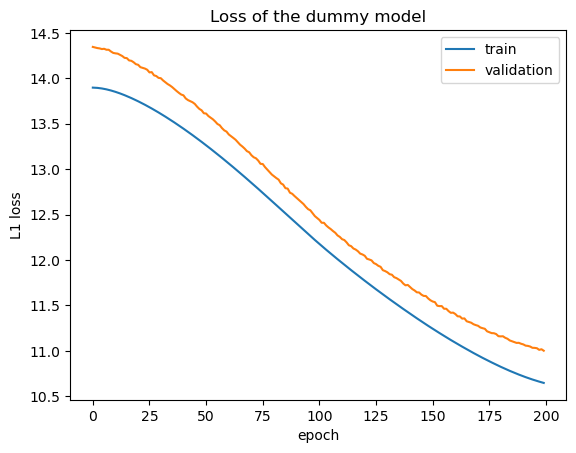

In [28]:
with open('./losses/loss_train_dummy_model.txt', 'r') as f : 
    loss_train = [float(elt) for elt in f.readlines()]

with open('./losses/loss_val_dummy_model.txt', 'r') as f :
    loss_val = [float(elt) for elt in f.readlines()]
plt.plot(loss_train, label='train')
plt.plot(loss_val, label='validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('L1 loss')
plt.title('Loss of the dummy model')
plt.show()


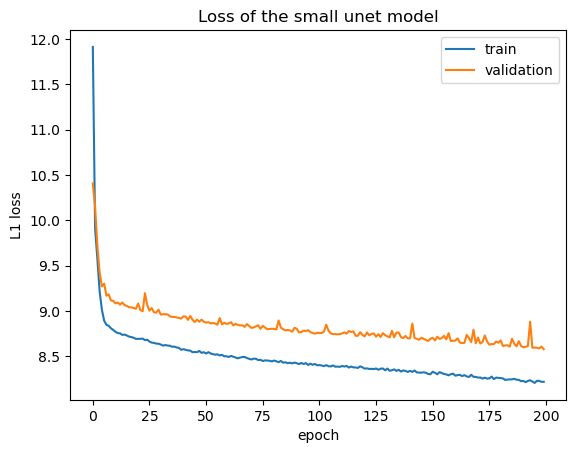

In [29]:
with open('./losses/loss_train_dummy_snd_test.txt', 'r') as f : 
    loss_train = [float(elt) for elt in f.readlines()]

with open('./losses/loss_val_dummy_snd_test.txt', 'r') as f :
    loss_val = [float(elt) for elt in f.readlines()]
plt.plot(loss_train, label='train')
plt.plot(loss_val, label='validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('L1 loss')
plt.title('Loss of the small unet model')
plt.show()


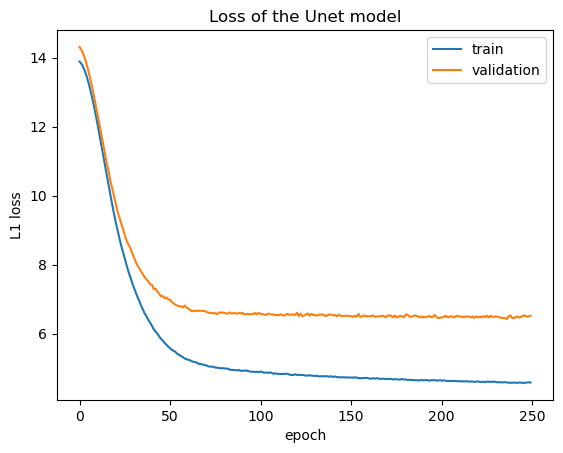

In [30]:
with open('./losses/loss_train_unet.txt', 'r') as f : 
    loss_train = [float(elt) for elt in f.readlines()]

with open('./losses/loss_val_unet.txt', 'r') as f :
    loss_val = [float(elt) for elt in f.readlines()]
plt.plot(loss_train, label='train')
plt.plot(loss_val, label='validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('L1 loss')
plt.title('Loss of the Unet model')
plt.show()

## Evaluation

test avec un fichier : 

In [31]:
index_to_test = 68

In [32]:
unet_test = unet_loaded
small_unet_test = small_unet_loaded
dummy_test = idiot_loaded

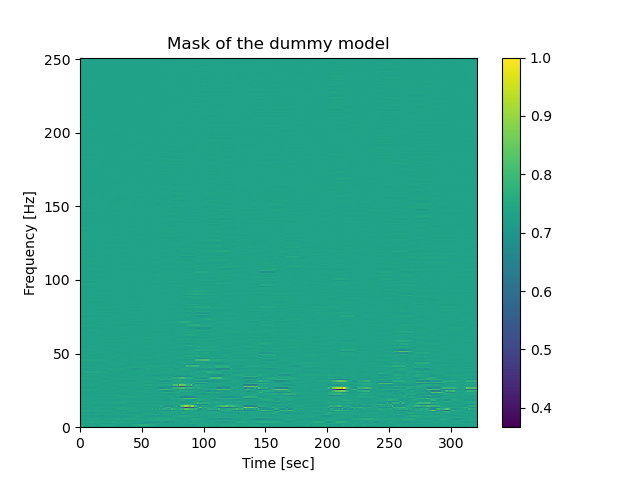

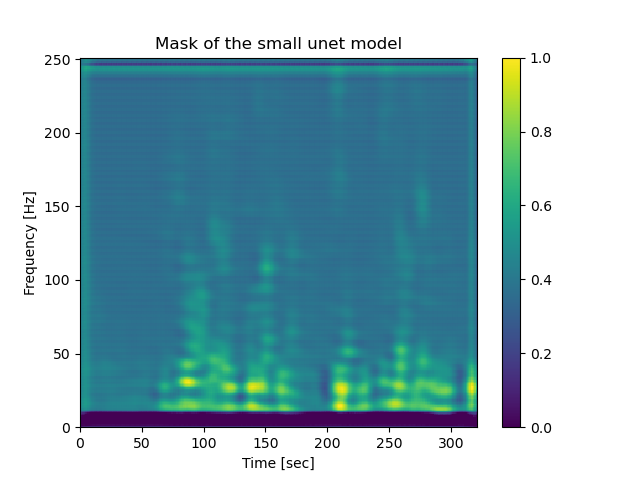

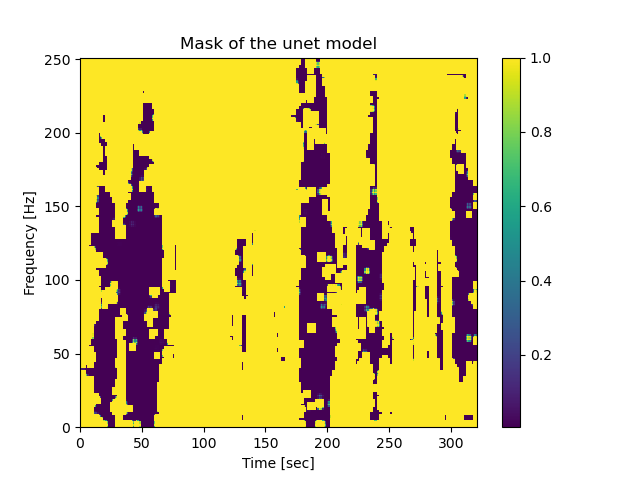

In [50]:
try : 
    samplerate, data = wavfile.read('data/Audio/denoising/test/test/'+ test_files_noise[index_to_test]) 
    _, _, Zxx = stft(data, fs=samplerate, nperseg=500)
    x=torch.tensor([[Zxx.real, Zxx.imag]])
    mask = dummy_test(x)
    mask = mask.detach().numpy()
    mask = np.abs(mask[0, 0])
    mask = mask / np.max(mask)
    # plot mask 
    plt.pcolormesh(mask)
    plt.title('Mask of the dummy model')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    # show colorbar
    plt.colorbar()
    plt.savefig('mask_dummy.png')
    plt.show()

    mask = small_unet_test(x)
    mask = mask.detach().numpy()
    mask = np.abs(mask[0, 0])
    mask = mask / np.max(mask)
    # plot mask 
    plt.pcolormesh(mask)
    plt.title('Mask of the small unet model')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    # show colorbar
    plt.colorbar()
    plt.savefig('mask_small_unet.png')
    plt.show()


    mask = unet_test(x)
    mask = mask.detach().numpy()
    mask = np.abs(mask[0, 0])
    mask = mask / np.max(mask)
    # plot mask 
    plt.pcolormesh(mask)
    plt.title('Mask of the unet model')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    # show colorbar
    plt.colorbar()
    plt.savefig('mask_unet.png')
    plt.show()
except :
    from PIL import Image
    img = Image.open('mask_dummy.png')
    display(img)
    img = Image.open('mask_small_unet.png')
    display(img)
    img = Image.open('mask_unet.png')
    display(img)

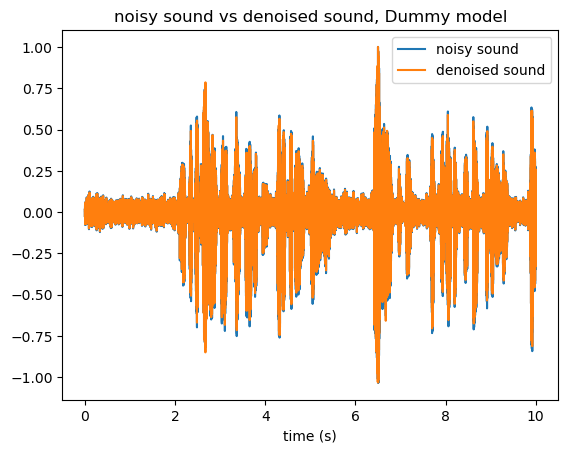

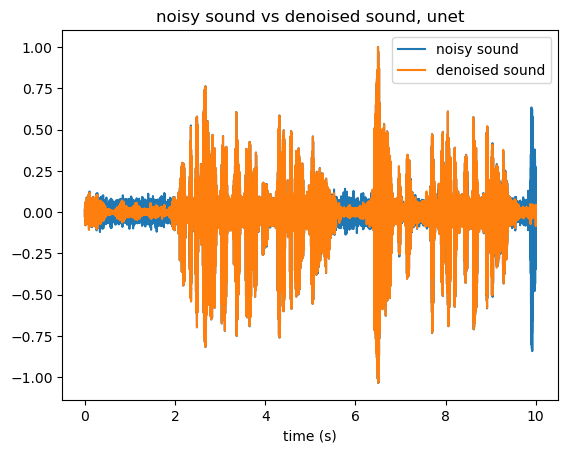

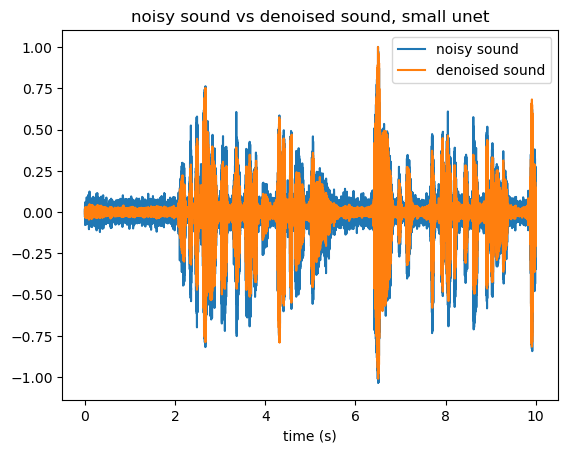

In [56]:
try : 
    samplerate, y_noisy = wavfile.read('data/Audio/denoising/test/test/'+ test_files_noise[index_to_test]) 
    _, y_clean = wavfile.read('data/Audio/voice_origin/test/test/'+ test_files_noise[index_to_test]) 
    # save both sounds 
    wavfile.write('data_test/noisy.wav', samplerate, y_noisy)
    wavfile.write('data_test/clean.wav', samplerate, y_clean)
except : 
    y_noisy = wavfile.read('data_test/noisy.wav')[1]
    y_clean = wavfile.read('data_test/clean.wav')[1]
    samplerate = 8000
def denoise(model, samplerate, data): # denoising an audio
    # le modele doit renvoyer un masque. 
    _, _, Zxx = stft(data, fs=samplerate, nperseg=500)
    assert Zxx.shape == (251, 321)
    x=torch.tensor([[Zxx.real, Zxx.imag]])
    mask = model(x)
    y_predicted = Zxx * mask.detach().numpy()
    _, y = istft(y_predicted, fs=samplerate)
    return y[0][0] / np.max(y[0][0])

y_denoised_dummy_model = denoise(dummy_test, samplerate, y_noisy)
plt.plot([i/ samplerate for i in range(len(y_noisy))],   y_noisy/np.max(y_noisy), label='noisy sound')
plt.plot([i/ samplerate for i in range(len(y_noisy))], y_denoised_dummy_model, label = 'denoised sound')
plt.legend()
plt.xlabel('time (s)')
plt.title('noisy sound vs denoised sound, Dummy model')
plt.show()
y_denoised_unet = denoise(unet_test, samplerate, y_noisy)
plt.plot([i/ samplerate for i in range(len(y_noisy))],   y_noisy/np.max(y_noisy), label='noisy sound')
plt.plot([i/ samplerate for i in range(len(y_noisy))], y_denoised_unet, label = 'denoised sound')
plt.legend()
plt.xlabel('time (s)')
plt.title('noisy sound vs denoised sound, unet')
plt.show()
y_denoised_small_unet = denoise(small_unet_loaded, samplerate, y_noisy)
plt.plot([i/ samplerate for i in range(len(y_noisy))],   y_noisy/np.max(y_noisy), label='noisy sound')
plt.plot([i/ samplerate for i in range(len(y_noisy))], y_denoised_small_unet, label = 'denoised sound')
plt.legend()
plt.xlabel('time (s)')
plt.title('noisy sound vs denoised sound, small unet')
plt.show()


son original : 

In [105]:
ipd.Audio(y_clean, rate=SAMPLERATE)

son bruité : 

In [106]:
ipd.Audio(y_noisy, rate=SAMPLERATE)

son débruité par dummy : 

In [107]:
ipd.Audio(y_denoised_dummy_model, rate=SAMPLERATE)

son débruité par unet

In [108]:
ipd.Audio(y_denoised_unet, rate=SAMPLERATE)

son débruité par small unet

In [109]:
ipd.Audio(y_denoised_small_unet, rate=SAMPLERATE)

In [110]:
original_stoi, new_stoi = stoi(y_noisy, y_clean, SAMPLERATE) , stoi(y_denoised_unet, y_clean, SAMPLERATE)
print(f"On passe d'un stoi de {original_stoi} à {new_stoi} en denoisant le signal avec unet")

original_stoi, new_stoi = stoi(y_noisy, y_clean, SAMPLERATE) , stoi(y_denoised_small_unet, y_clean, SAMPLERATE)
print(f"On passe d'un stoi de {original_stoi} à {new_stoi} en denoisant le signal avec small unet")

original_stoi, new_stoi = stoi(y_noisy, y_clean, SAMPLERATE) , stoi(y_denoised_dummy_model, y_clean, SAMPLERATE)
print(f"On passe d'un stoi de {original_stoi} à {new_stoi} en denoisant le signal avec dummy model")

On passe d'un stoi de 0.6256735682464195 à 0.7407825101828317 en denoisant le signal avec unet
On passe d'un stoi de 0.6256735682464195 à 0.6363598559537734 en denoisant le signal avec small unet
On passe d'un stoi de 0.6256735682464195 à 0.6246817044789791 en denoisant le signal avec dummy model


In [91]:
def compute_stoi(model, test_files_noise, test_files_clean):
    stoi_values = []
    for i in range(len(test_files_noise)):
        samplerate, data = wavfile.read('data/Audio/denoising/test/test/'+ test_files_noise[i]) 
        y = denoise(model, samplerate, data)
        _, data_clean = wavfile.read('data/Audio/voice_origin/test/test/'+ test_files_clean[i])
        stoi_values.append(stoi(data_clean, y, SAMPLERATE, extended=False))
    return np.mean(stoi_values)

In [92]:
stoi_unet = compute_stoi(unet_test, test_files_noise, test_files_clean)
stoi_small_unet = compute_stoi(small_unet_test, test_files_noise, test_files_clean)
stoi_dummy = compute_stoi(dummy_test, test_files_noise, test_files_clean)
print(f"Le stoi moyen pour le modèle dummy est de {stoi_dummy}, pour le modèle unet de {stoi_unet} et pour le modèle small unet de {stoi_small_unet}")


Le stoi moyen pour le modèle dummy est de 0.9251321245938533, pour le modèle unet de 0.9195135710949146 et pour le modèle small unet de 0.9266477516868771


(0.9, 0.93)

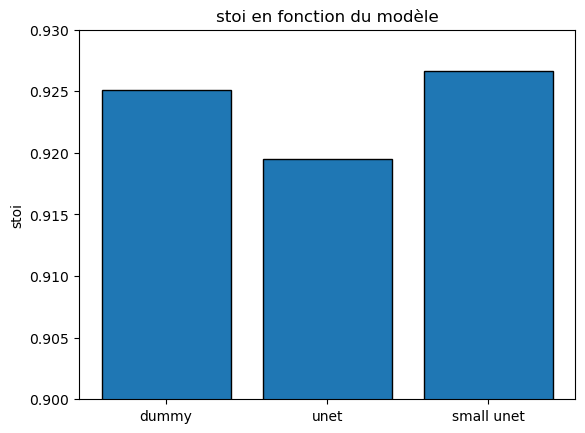

In [8]:
stoi_unet = 0.9195135710949146
stoi_small_unet = 0.926647751686877
stoi_dummy = 0.9251321245938533

plt.bar(['dummy', 'unet', 'small unet'], [stoi_dummy, stoi_unet, stoi_small_unet], edgecolor='black')
plt.ylabel('stoi')
plt.title('stoi en fonction du modèle')
plt.ylim(0.9, 0.93)

Conclusion : 

STFT : 

- Des résultats meilleurs avec un small unet
- Unet overfitte probablement

Idées d'amélioration : 

- Entraîner sur le spectrogramme pour avoir la puissance plutôt que des nombres complexes + normaliser les données. 
- Utiliser d'autres loss pour étudier leur impact
- Faire de l'augmentation de données avec des bruits différents, des bruits gaussiens... 
